In [5]:
#Sentiment analysis on expert textual reviews to get an “expert likeability-score”
#Correlation analysis (statistical tests) between gross sales, likeability score, and expert ratings

#Clustering of plot keywords amongst plots (pre-filtering using a standards tokenization pipileine 
#(normalization, postword removal, stemming, and, in our case, removing verbs))

#Clustering of review keywords for different expert textual reviews/consensus on “qualitative” movies.



In [6]:
# sentiment scores + ratings of eaach movie

To perform our quality analysis we extend our initial dataset with several "Rotten Tomatoes" dataset, in order to access useful indicators of popularity. The useful indicators we want to study now are : the box-office, the expert critic reviews, the expert critic score, the movie rewards.
By merging multiple datasets and observe their size and content we will discuss the feasability of the next operations, for example statistical analysis.


In [7]:
import os
from copy import deepcopy
from itertools import permutations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind, pearsonr
import seaborn as sns

DATA_DIR = "../data/raw/"
INIT_DATABASE = DATA_DIR + "movie.metadata.tsv"
TOP_MOVIES_RT = DATA_DIR + "rotten_tomatoes_top_movies.csv"
OSCARS = DATA_DIR + "the_oscar_award.csv"


In [8]:
df_ratings_expert = pd.read_csv('ratings_expert.csv') # comedies with mean rating scores
df_reviews_compound = pd.read_csv('reviews_with_compound.csv') # all movies RT+CMU with sentiment analysis scores
comedy_ids = df_ratings_expert['id']


In [9]:
def standardize_score(note):
    if isinstance(note, str) and '/' in note:
        try:
            numerator, denominator = map(float, note.split('/'))
            if denominator == 0:  
                return None
            if (numerator / denominator)<=1 :
                return numerator / denominator
        except (ValueError, TypeError): 
            return None
    else:
        return None

def normalize_sa(value):
    return (value + 1) / 2

def zscore(series):
    mean = series.mean()
    std_dev = series.std()
    return (series - mean) / std_dev



def scatter_plot_corr(df_tuple, col1, col2, merge_col, movie_type):
    df1,df2 = df_tuple 
    df_corr = pd.merge(df1, df2, on=merge_col)
    
    #correlation_value = df_corr[col1].corr(df_corr[col2])
    correlation_value, p_value = pearsonr(df_corr[col1], df_corr[col2]) 
    plt.figure(figsize=(8, 6))
    sns.regplot(x = col1, y = col2, data= df_corr, ci=None, line_kws={"color": "red"})
    plt.title(f"Scatter Plot with correlation {movie_type}: {correlation_value:.2f}")
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.show()



def ttest_and_boxplot (df_comedy_tuple, df_not_comedy_tuple, column, expert_str):
    
    df_comedy_score, df_comedy_sa = df_comedy_tuple
    df_not_comedy_score, df_not_comedy_sa = df_not_comedy_tuple
    comedies = df_comedy_sa[column]
    not_comedies = df_not_comedy_sa[column]

    t_stat, p_value = ttest_ind(comedies, not_comedies, equal_var=False)
    print(f"T-Statistic: {t_stat:.2f}")
    print(f"P-Value: {p_value:.4f}")

    if p_value < 0.05:
        print("Conclusion: Significant difference between the two groups.")
    else:
        print("Conclusion: No significant difference between the two groups.")
    
    comedies_df = pd.DataFrame({column: comedies, 'Group': 'Comedy'})
    not_comedies_df = pd.DataFrame({column: not_comedies, 'Group': 'Non-Comedy'})
    combined_df = pd.concat([comedies_df, not_comedies_df])

    
    summary_stats = combined_df.groupby('Group')[column].describe()
    print(summary_stats)

    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Group', y=column, data=combined_df, palette='coolwarm')
    plt.title(f"{column} distribution of {expert_str}  : Comedy vs. Non-Comedy")
    plt.xlabel("Movie Type")
    plt.ylabel(column)
    plt.show()



In [10]:
def preprocess_df_for_correlation(df, col1, col2, merge_col, expert, comedy):
        
    df = df[df['isTopCritic'] == expert]

    if comedy == True :
        df = df[df[merge_col].isin(comedy_ids)]
    else :
        df = df[~df[merge_col].isin(comedy_ids)]

    df[col1] = df[col1].apply(standardize_score)
    df[col2] = df[col2].apply(normalize_sa)
    
    df1 = df.groupby(merge_col)[col1].mean().reset_index()
    df2 = df.groupby(merge_col)[col2].mean().reset_index()
    df1 = df1.dropna()
    df2 = df2.dropna()

    return df1, df2 


def preprocess_w_zscore(df, col1, col2, merge_col, expert, comedy):

    df = df[df['isTopCritic'] == expert]

    if comedy == True :
        df = df[df[merge_col].isin(comedy_ids)]
    else :
        df = df[~df[merge_col].isin(comedy_ids)]

    df[col1] = df[col1].apply(standardize_score)
    df[col2] = zscore(df[col2])
    
    df1 = df.groupby(merge_col)[col1].mean().reset_index()
    df2 = df.groupby(merge_col)[col2].mean().reset_index()
    df1 = df1.dropna()
    df2 = df2.dropna()

    return df1, df2
    


In [11]:
df_expert_comedies= preprocess_df_for_correlation(df_reviews_compound, 'originalScore', 'sa', 'id', True, True)
df_non_expert_comedies = preprocess_df_for_correlation(df_reviews_compound, 'originalScore', 'sa', 'id', False, True)
df_expert_not_comedies = preprocess_df_for_correlation(df_reviews_compound, 'originalScore', 'sa', 'id', True, False)
df_non_expert_not_comedies = preprocess_df_for_correlation(df_reviews_compound, 'originalScore', 'sa', 'id', False, False)

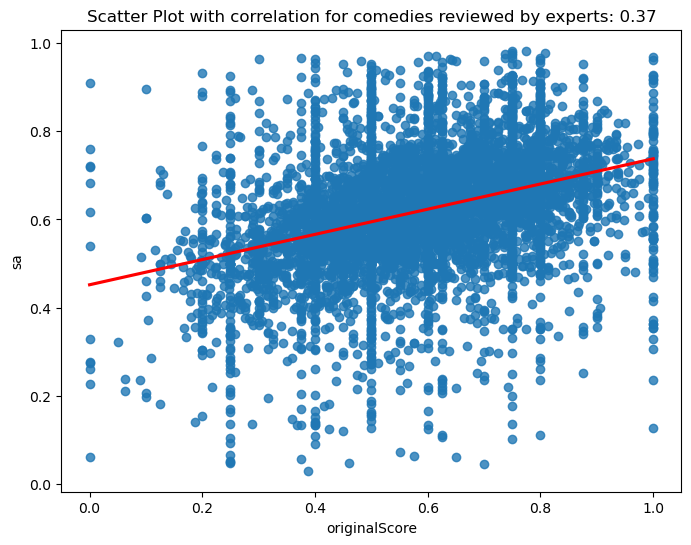

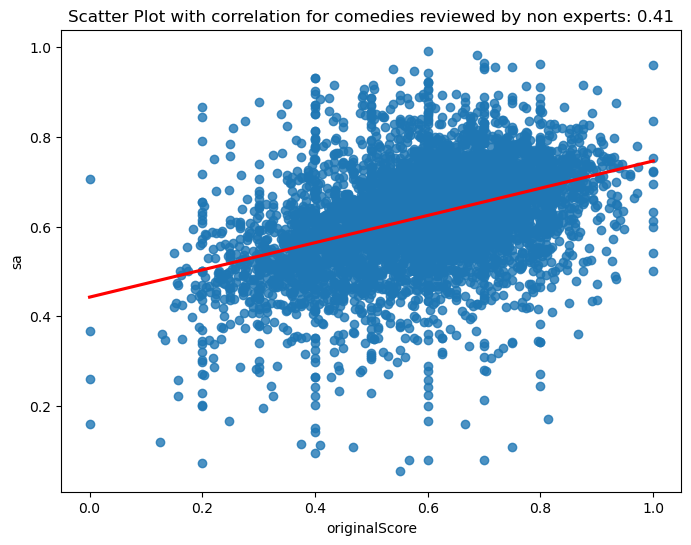

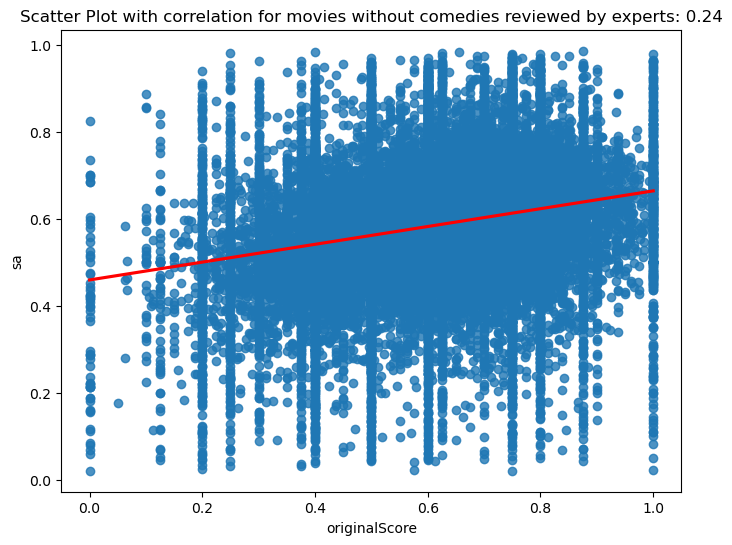

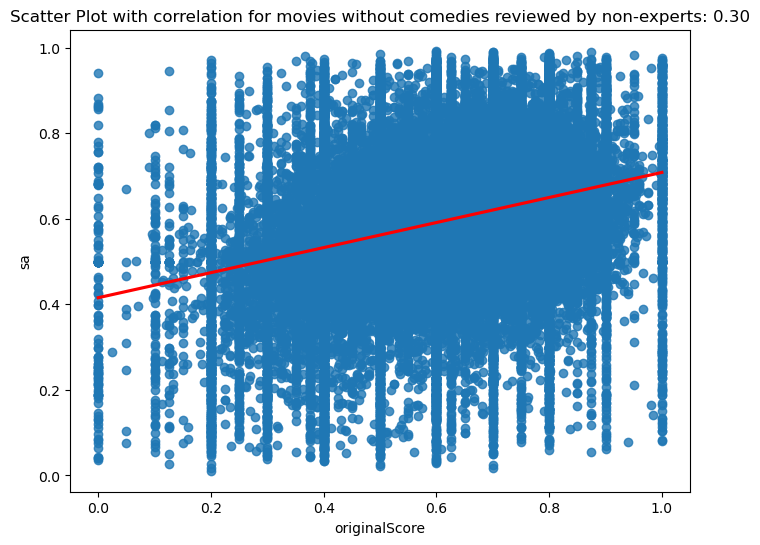

In [12]:
scatter_plot_corr(df_expert_comedies, 'originalScore' ,'sa', 'id', 'for comedies reviewed by experts')
scatter_plot_corr(df_non_expert_comedies, 'originalScore' ,'sa', 'id', 'for comedies reviewed by non experts')
scatter_plot_corr(df_expert_not_comedies, 'originalScore' ,'sa', 'id', 'for movies without comedies reviewed by experts')
scatter_plot_corr(df_non_expert_not_comedies, 'originalScore' ,'sa', 'id', 'for movies without comedies reviewed by non-experts')

T-Statistic: 14.74
P-Value: 0.0000
Conclusion: Significant difference between the two groups.
              count      mean       std      min       25%       50%  \
Group                                                                  
Comedy       5580.0  0.619087  0.140349  0.03090  0.539421  0.625339   
Non-Comedy  33805.0  0.588119  0.172688  0.01145  0.500000  0.596907   

                 75%      max  
Group                          
Comedy      0.705303  0.98225  
Non-Comedy  0.700950  0.98600  


C:\Users\theol\AppData\Local\Temp\ipykernel_78432\3060846398.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=column, data=combined_df, palette='coolwarm')


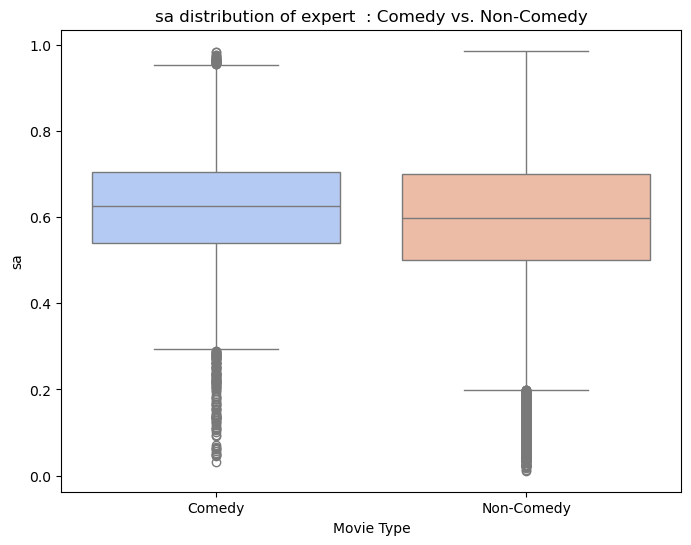

In [13]:
ttest_and_boxplot(df_expert_comedies, df_expert_not_comedies, 'sa', 'expert')

T-Statistic: 13.24
P-Value: 0.0000
Conclusion: Significant difference between the two groups.
              count      mean       std      min       25%       50%  \
Group                                                                  
Comedy       5626.0  0.621556  0.117788  0.05575  0.551984  0.629141   
Non-Comedy  57549.0  0.598496  0.180355  0.01030  0.500000  0.607507   

                 75%      max  
Group                          
Comedy      0.700033  0.99205  
Non-Comedy  0.720200  0.99325  


C:\Users\theol\AppData\Local\Temp\ipykernel_78432\3060846398.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Group', y=column, data=combined_df, palette='coolwarm')


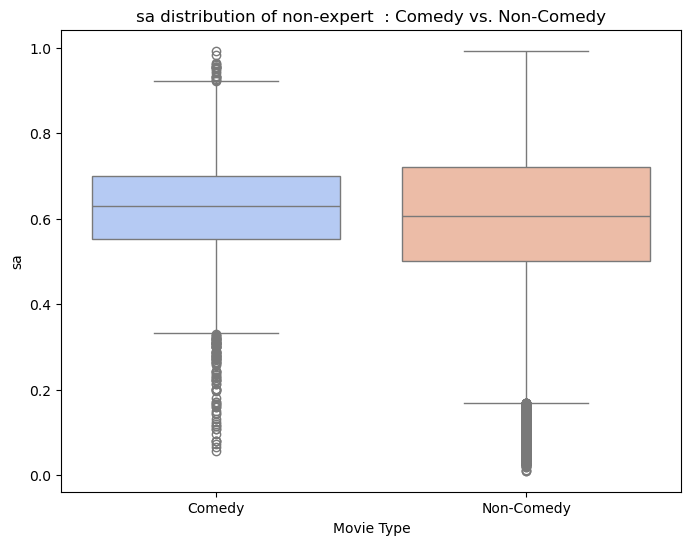

In [14]:
ttest_and_boxplot(df_non_expert_comedies, df_non_expert_not_comedies, 'sa', 'non-expert') 

In [15]:
# for correlation sort datasets between comedies and non-comedies / expert and non-expert
#expert / non-expert => isTopCritic = True /False
#comedies and non-comedies => comedy_ids isin or isnot_in
# 1 dataset with comedy_ids + mean score = ratings_expert

# review compounds treatment 
# apply(standardize_score)
# apply(normalize sa)
# comedy_ids
# 2 df => 1 with id+mean_score and 1 with id+mean_sa => merge 


    